[Tensorflow Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import IPython

import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2022-01-26 16:38:33.469882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-26 16:38:33.469980: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [39]:
df = pd.read_csv("data_by_location/1001.csv", parse_dates=['fecha'])
df = df.fillna(method="ffill").fillna(method="bfill")
df['fecha'] = pd.to_datetime(df.fecha)
df.set_index('fecha', inplace=True)
df.head()

,intensidad,ocupacion,vmed
fecha,,,
2021-01-01 00:00:00,144,0.0,55.0
2021-01-01 00:15:00,84,0.0,56.0
2021-01-01 00:30:00,108,0.0,55.0
2021-01-01 00:45:00,792,1.0,59.0
2021-01-01 01:00:00,1704,4.0,61.0


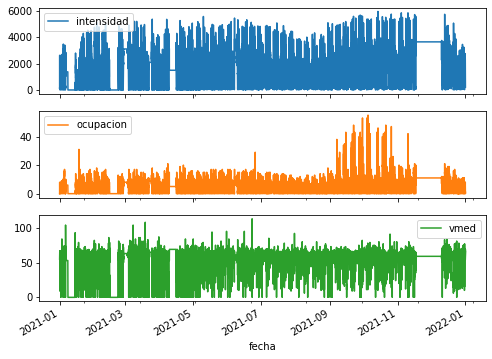

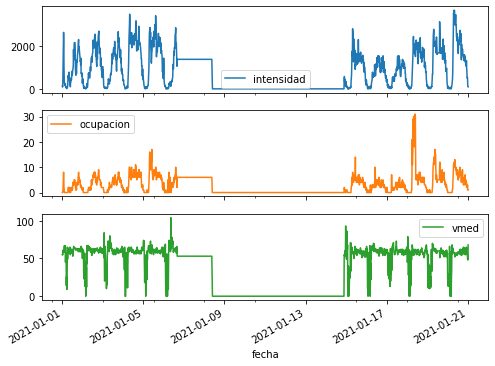

In [4]:
_ = df.plot(subplots=True)

_ = df[:20*4*24].plot(subplots=True)

In [48]:
df[df.intensidad == 0].index.month.value_counts()

2     773
1     665
3      61
4      53
5      26
6       9
7       7
9       7
8       6
11      5
10      4
12      2
Name: fecha, dtype: int64

In [49]:
df[df.intensidad == 3660].index.month.value_counts()

11    1304
12     915
6        5
2        4
4        4
7        4
10       4
3        3
9        3
5        2
8        2
1        1
Name: fecha, dtype: int64

In [59]:
df[df.intensidad == 2100].index.month.value_counts()

6     189
7      57
9      18
8      17
10     13
Name: fecha, dtype: int64

In [71]:
df = df["2021-06-10" : "2021-10-31"]

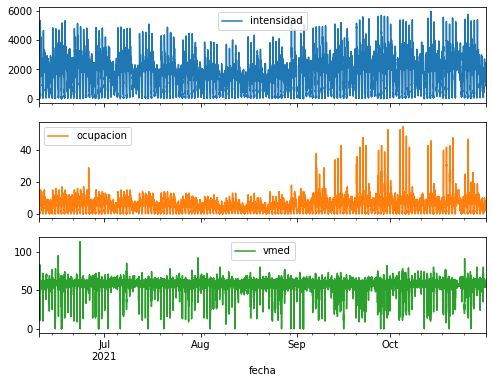

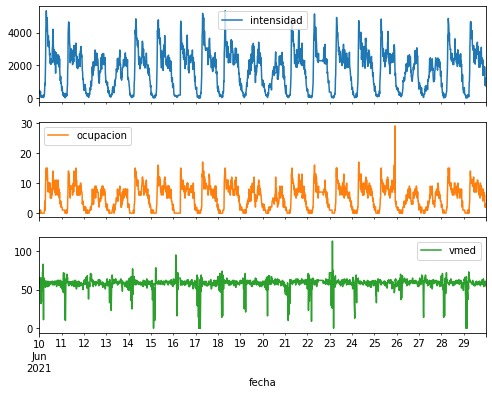

In [72]:
_ = df.plot(subplots=True)

_ = df[:20*4*24].plot(subplots=True)

In [73]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df.loc[:, 'Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df.loc[:, 'Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df.loc[:, 'Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df.loc[:, 'Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

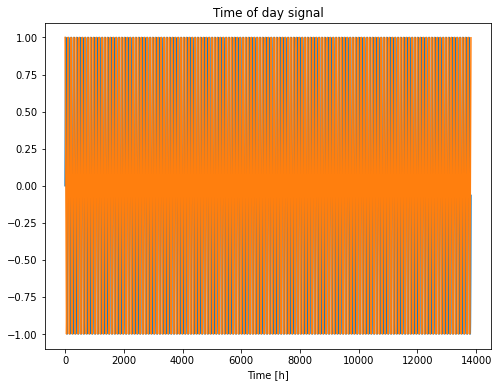

In [74]:
plt.plot(np.array(df['Day sin']))
plt.plot(np.array(df['Day cos']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

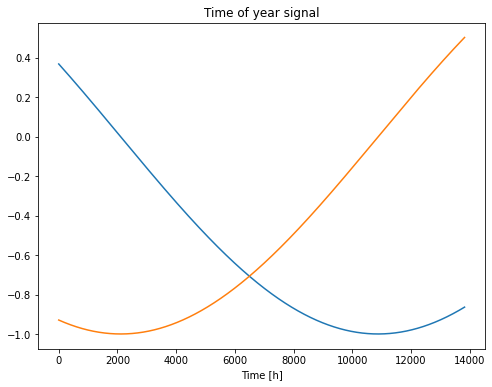

In [75]:
plt.plot(np.array(df['Year sin']))
plt.plot(np.array(df['Year cos']))
plt.xlabel('Time [h]')
plt.title('Time of year signal')

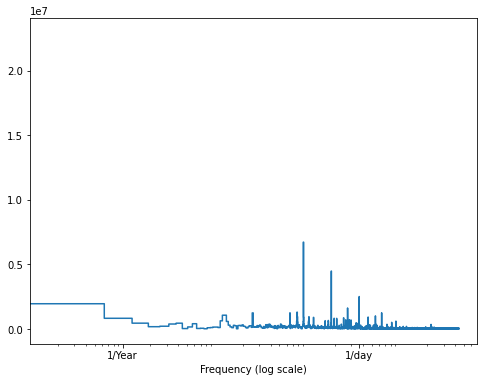

In [77]:
fft = tf.signal.rfft(df['intensidad'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['intensidad'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [78]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [79]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

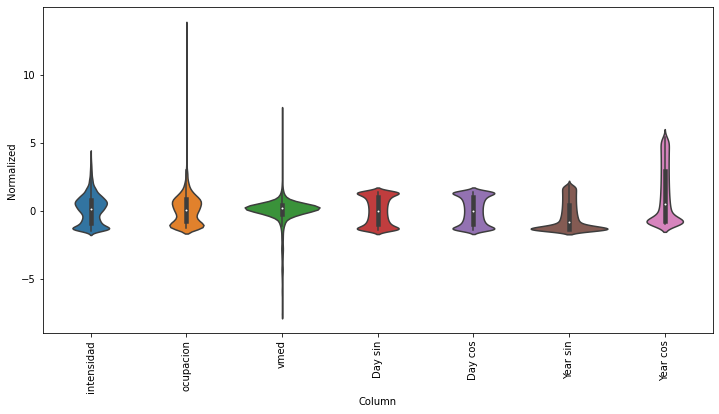

In [80]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [81]:
df

,intensidad,ocupacion,vmed,Day sin,Day cos,Year sin,Year cos
fecha,,,,,,,
2021-06-10 00:00:00,336,1.0,58.0,-2.185888e-12,1.000000,0.369311,-0.929306
2021-06-10 00:15:00,456,1.0,62.0,6.540313e-02,0.997859,0.369145,-0.929372
2021-06-10 00:30:00,276,0.0,66.0,1.305262e-01,0.991445,0.368978,-0.929438
2021-06-10 00:45:00,336,0.0,61.0,1.950903e-01,0.980785,0.368811,-0.929504
2021-06-10 01:00:00,252,0.0,52.0,2.588190e-01,0.965926,0.368645,-0.929570
...,...,...,...,...,...,...,...
2021-10-31 22:45:00,1272,5.0,57.0,-3.214395e-01,0.946930,-0.864199,0.503150
2021-10-31 23:00:00,888,2.0,56.0,-2.588190e-01,0.965926,-0.864109,0.503305
2021-10-31 23:15:00,900,2.0,54.0,-1.950903e-01,0.980785,-0.864019,0.503460


In [82]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
              self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [83]:
# Dada una hora de datos, predice el tráfico exactamente una hora después
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['intensidad'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['intensidad']

In [84]:
# Dadas 4 horas datos, predice el tráfico 3 horas después, durante una hora
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['intensidad'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['intensidad']

In [85]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [86]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
Labels shape: (3, 1, 1)


In [87]:
w2.example = example_inputs, example_labels

In [88]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w1.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 48, 7)
Inputs shape: (3, 24, 7)
Labels shape: (3, 1, 1)


In [89]:
def plot(self, model=None, plot_col='intensidad', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

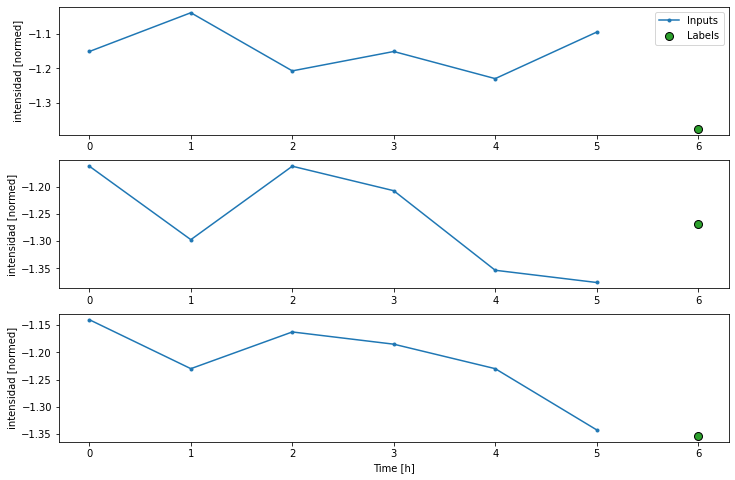

In [90]:
w2.plot(plot_col='intensidad')

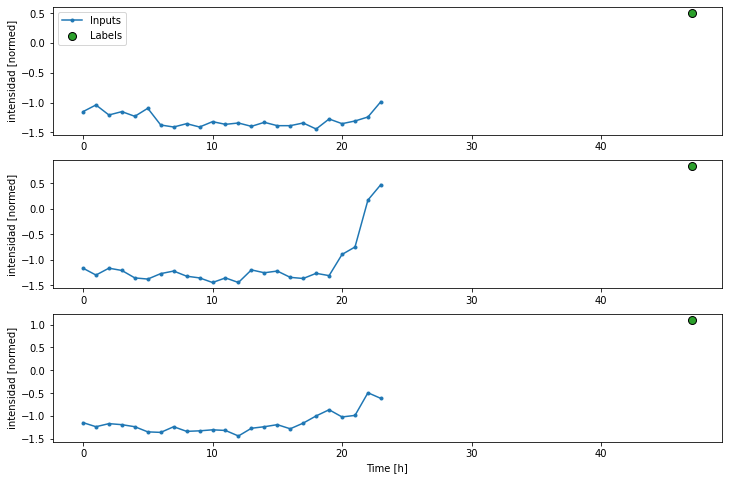

In [91]:
w1.plot(plot_col='intensidad')

In [92]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [93]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [94]:
# Each element is an (inputs, label) pair.
w2.train.element_spec


(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [95]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [96]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['intensidad'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['intensidad']

In [97]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [98]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [99]:
baseline = Baseline(label_index=column_indices['intensidad'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

87/87 [==============================] - 2s 10ms/step - loss: 0.1327 - mean_absolute_error: 0.2492


In [100]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['intensidad'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['intensidad']

In [101]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


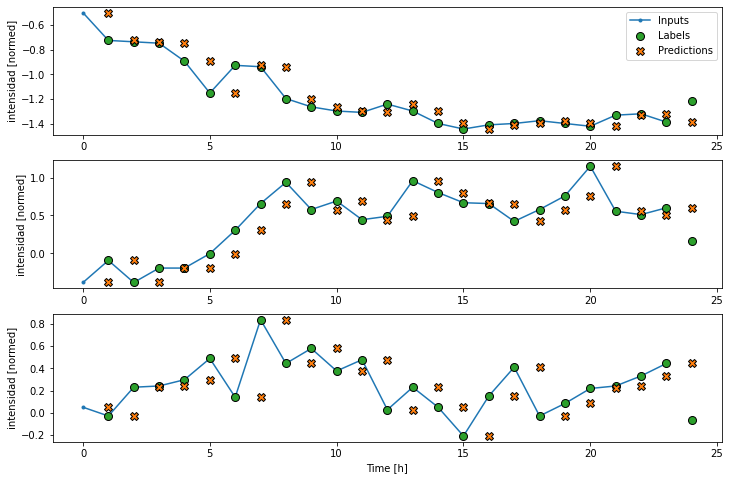

In [102]:
wide_window.plot(baseline)

In [103]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [104]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


In [105]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [106]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['intensidad']

In [107]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
303/303 [==============================] - 6s 14ms/step - loss: 0.4278 - mean_absolute_error: 0.4979 - val_loss: 2.6915 - val_mean_absolute_error: 1.4272
Epoch 2/200
303/303 [==============================] - 3s 11ms/step - loss: 0.1843 - mean_absolute_error: 0.3181 - val_loss: 1.2815 - val_mean_absolute_error: 0.8961
Epoch 3/200
303/303 [==============================] - 4s 12ms/step - loss: 0.1474 - mean_absolute_error: 0.2833 - val_loss: 0.8578 - val_mean_absolute_error: 0.6995
Epoch 4/200
303/303 [==============================] - 4s 13ms/step - loss: 0.1340 - mean_absolute_error: 0.2690 - val_loss: 0.6515 - val_mean_absolute_error: 0.5981
Epoch 5/200
303/303 [==============================] - 4s 11ms/step - loss: 0.1236 - mean_absolute_error: 0.2575 - val_loss: 0.4799 - val_mean_absolute_error: 0.5063
Epoch 6/200
303/303 [==============================] - 3s 10ms/step - loss: 0.1155 - mean_absolute_error: 0.2479 - val_loss: 0.3654 - val_mean_absolute_error: 0.4364
Epoc

In [108]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['intensidad']

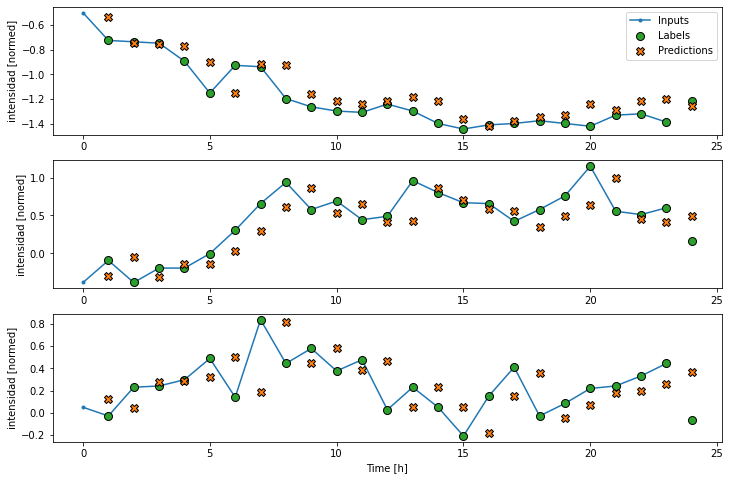

In [109]:
wide_window.plot(linear)

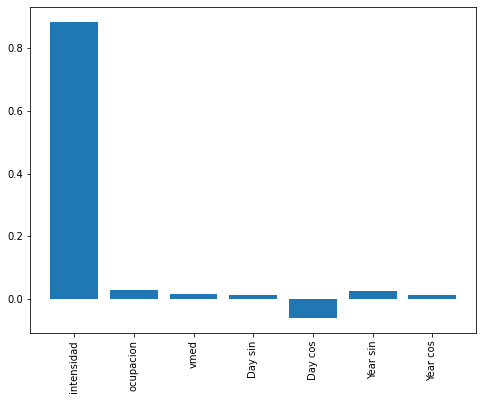

In [110]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


In [111]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
303/303 [==============================] - 6s 14ms/step - loss: 0.1394 - mean_absolute_error: 0.2574 - val_loss: 0.1195 - val_mean_absolute_error: 0.2495
Epoch 2/200
303/303 [==============================] - 3s 11ms/step - loss: 0.0808 - mean_absolute_error: 0.2069 - val_loss: 0.1148 - val_mean_absolute_error: 0.2494
Epoch 3/200
303/303 [==============================] - 4s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.2022 - val_loss: 0.1166 - val_mean_absolute_error: 0.2505
Epoch 4/200
87/87 [==============================] - 1s 9ms/step - loss: 0.1221 - mean_absolute_error: 0.2564


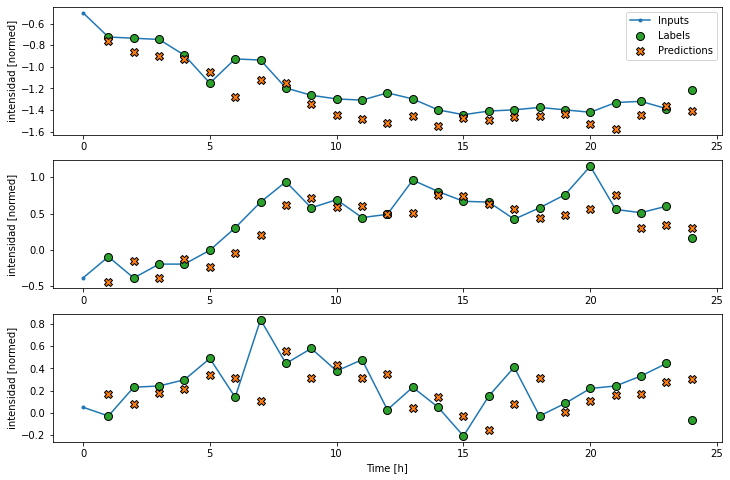

In [112]:
wide_window.plot(dense)

In [113]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['intensidad'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['intensidad']

Text(0.5, 1.0, 'Given 45 minutes of inputs, predict 15 minutes into the future.')

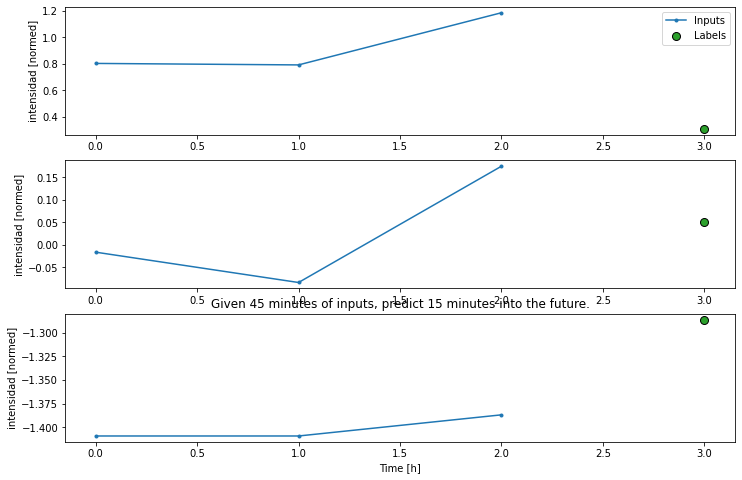

In [114]:
conv_window.plot()
plt.title("Given 45 minutes of inputs, predict 15 minutes into the future.")

In [115]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [116]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [117]:
history = compile_and_fit(multi_step_dense, conv_window)

#IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/200
303/303 [==============================] - 5s 12ms/step - loss: 0.1780 - mean_absolute_error: 0.2913 - val_loss: 0.1914 - val_mean_absolute_error: 0.3149
Epoch 2/200
303/303 [==============================] - 3s 10ms/step - loss: 0.0874 - mean_absolute_error: 0.2179 - val_loss: 0.1473 - val_mean_absolute_error: 0.2829
Epoch 3/200
303/303 [==============================] - 4s 11ms/step - loss: 0.0811 - mean_absolute_error: 0.2092 - val_loss: 0.1958 - val_mean_absolute_error: 0.3453
Epoch 4/200
87/87 [==============================] - 1s 7ms/step - loss: 0.1492 - mean_absolute_error: 0.2858


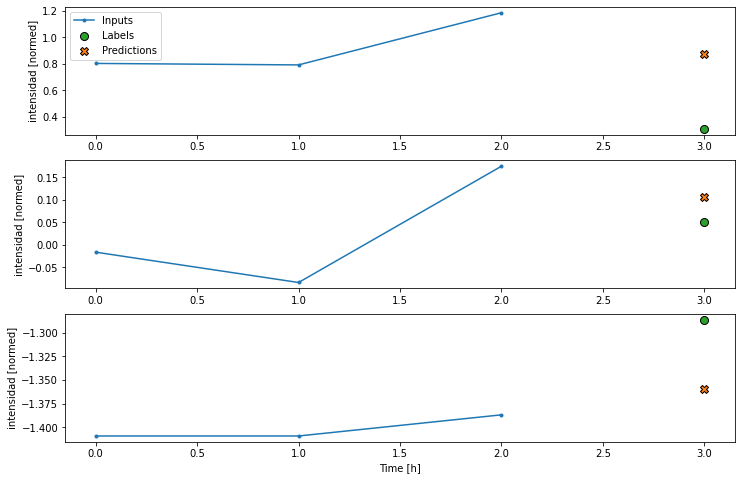

In [118]:
conv_window.plot(multi_step_dense)

In [119]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 7)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1of input shape to have value 21, but received input with shape (32, 168)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 7), dtype=float32)
  • training=None
  • mask=None


In [120]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [121]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [123]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

87/87 [==============================] - 1s 8ms/step - loss: 0.1214 - mean_absolute_error: 0.2534


In [124]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [125]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['intensidad'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['intensidad']

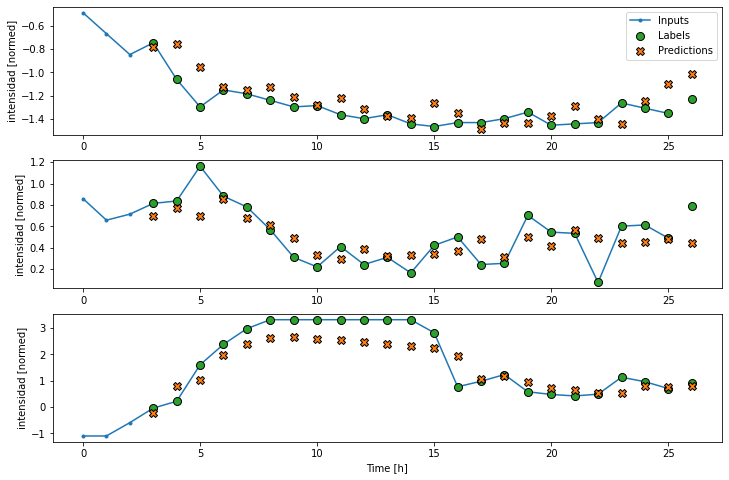

In [126]:
wide_conv_window.plot(conv_model)

In [127]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [128]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


In [129]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

86/86 [==============================] - 2s 19ms/step - loss: 0.1083 - mean_absolute_error: 0.2347


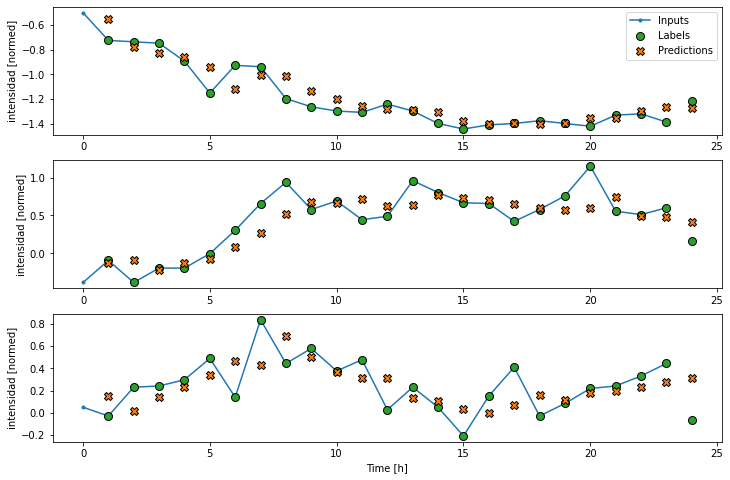

In [130]:
wide_window.plot(lstm_model)

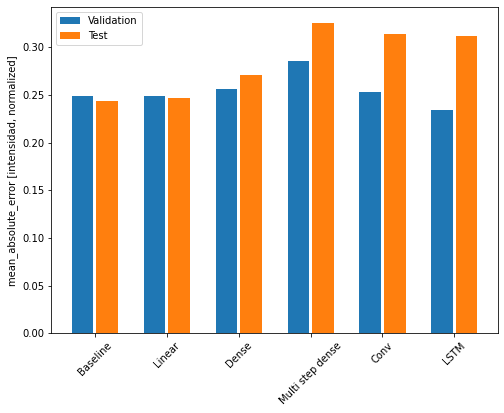

In [132]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [intensidad, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [133]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.2432
Linear      : 0.2464
Dense       : 0.2708
Multi step dense: 0.3258
Conv        : 0.3138
LSTM        : 0.3123


In [134]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 7)
Labels shape (batch, time, features): (32, 24, 7)


In [135]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [136]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

86/86 [==============================] - 1s 7ms/step - loss: 0.2737 - mean_absolute_error: 0.1945


In [137]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [138]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

87/87 [==============================] - 1s 8ms/step - loss: 0.2379 - mean_absolute_error: 0.2391


In [139]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

86/86 [==============================] - 2s 20ms/step - loss: 0.2571 - mean_absolute_error: 0.2670

CPU times: user 6min 20s, sys: 33.7 s, total: 6min 54s
Wall time: 4min 55s


In [140]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [141]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

86/86 [==============================] - 2s 19ms/step - loss: 0.2115 - mean_absolute_error: 0.1804

CPU times: user 1min 56s, sys: 10 s, total: 2min 6s
Wall time: 1min 14s


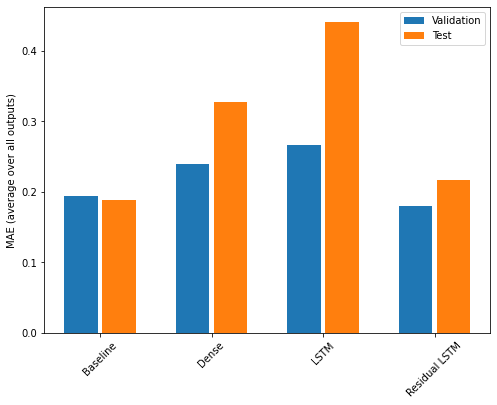

In [142]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [143]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1879
Dense          : 0.3281
LSTM           : 0.4407
Residual LSTM  : 0.2166


Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): None

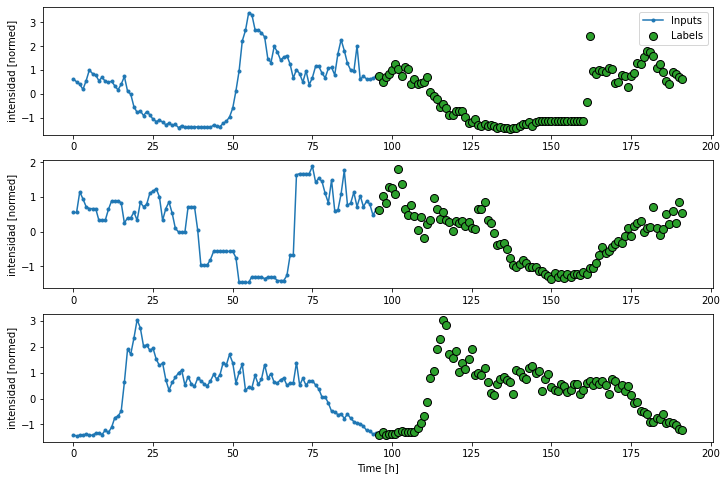

In [144]:
INPUT_STEPS = 24*4
OUT_STEPS = 24*4
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

81/81 [==============================] - 1s 8ms/step - loss: 2.5774 - mean_absolute_error: 0.9338


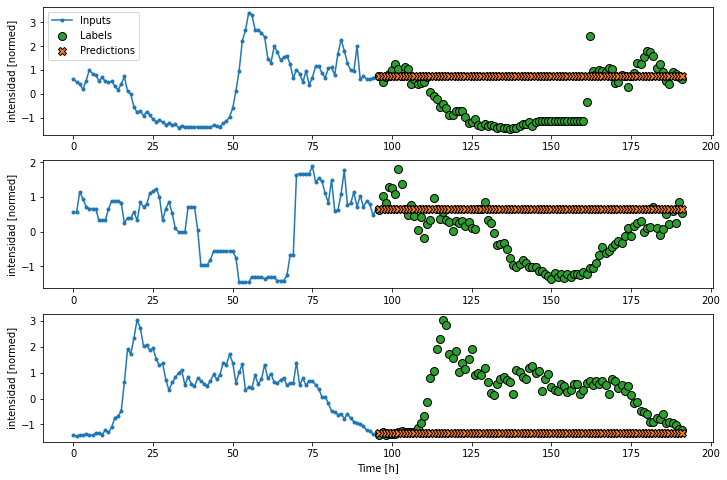

In [145]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

81/81 [==============================] - 1s 8ms/step - loss: 0.7133 - mean_absolute_error: 0.2920


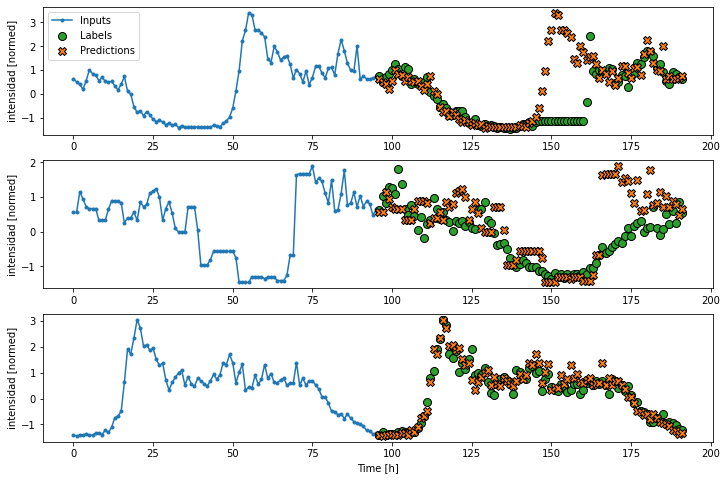

In [146]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


81/81 [==============================] - 1s 11ms/step - loss: 0.8279 - mean_absolute_error: 0.3446


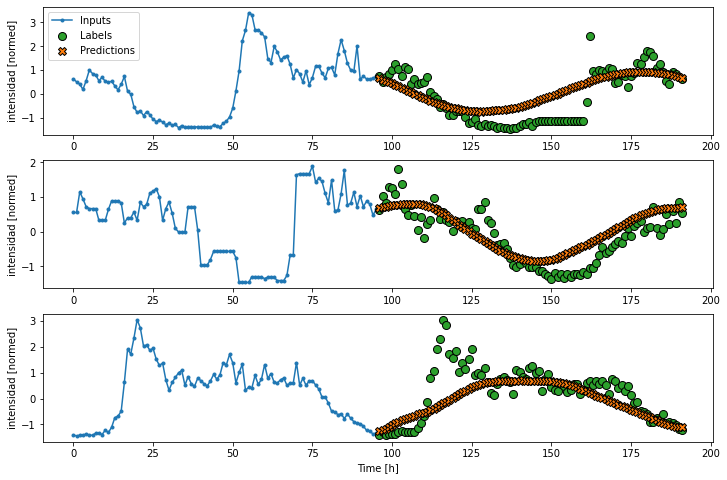

In [147]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

4/4 [==============================] - 0s 9ms/step - loss: 0.2428 - mean_absolute_error: 0.2724


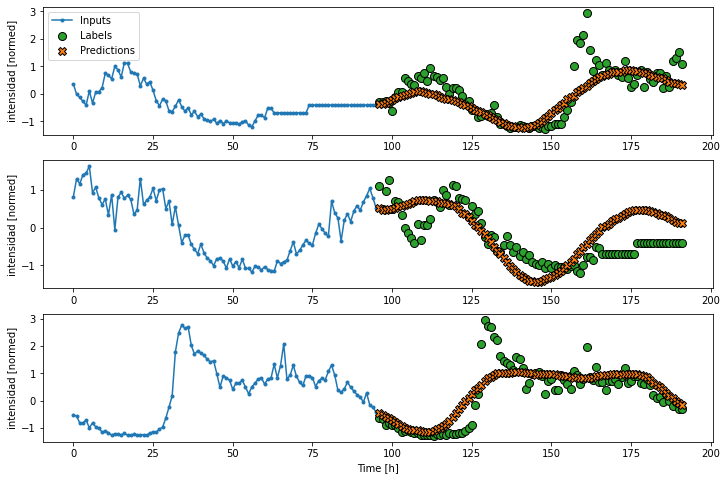

In [88]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

4/4 [==============================] - 0s 8ms/step - loss: 0.2509 - mean_absolute_error: 0.2900


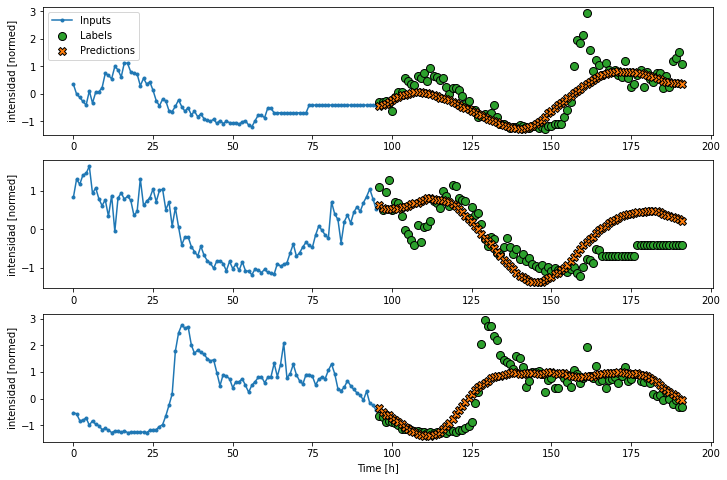

In [89]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

4/4 [==============================] - 0s 31ms/step - loss: 0.4229 - mean_absolute_error: 0.5093


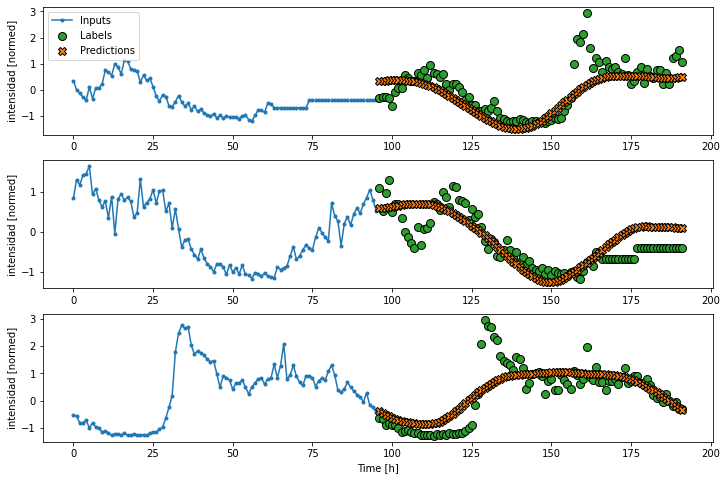

In [90]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [92]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [93]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [94]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [95]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 7])

In [96]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call


In [97]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 96, 7)


4/4 [==============================] - 0s 52ms/step - loss: 0.7719 - mean_absolute_error: 0.6910


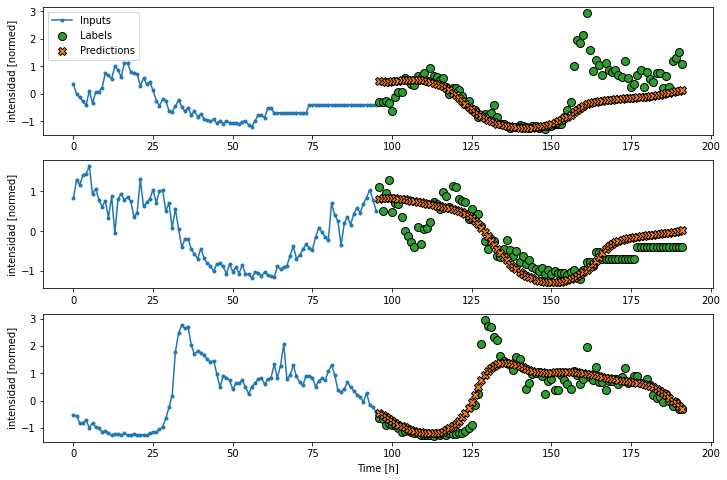

In [98]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [99]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

IndexError: list index out of range

In [103]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

IndexError: list index out of range

In [104]:
multi_performance.items()

dict_items([('Last', [])])